In [1]:
#Import the necessary Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style as style
from matplotlib.patches import Rectangle
import seaborn as sb
%matplotlib inline
#set diagram parameters

base_color = sb.color_palette()[1]
style.use('seaborn')

### Getting to Know Seattle's Data

In [2]:
# Read in the Boston Data
df_sea = pd.read_csv('./listings_seattle.csv')
df_sea.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2318,Casa Madrona - Urban Oasis 1 block from the park!,2536,Megan,Central Area,Madrona,47.61094,-122.29286,Entire home/apt,349,30,32,2020-02-01,0.21,2,107
1,9419,Glorious sun room w/ memory foambed,30559,Angielena,Other neighborhoods,Georgetown,47.55017,-122.31937,Private room,55,2,148,2019-12-27,1.14,7,352
2,9531,The Adorable Sweet Orange Craftsman,31481,Cassie,West Seattle,Fairmount Park,47.55539,-122.38474,Entire home/apt,165,3,41,2020-11-26,0.37,2,210
3,9534,The Coolest Tangerine Dream MIL!,31481,Cassie,West Seattle,Fairmount Park,47.55624,-122.38598,Entire home/apt,125,3,56,2021-02-19,0.50,2,217
4,9596,"the down home , spacious, central and fab!",14942,Joyce,Other neighborhoods,Wallingford,47.65479,-122.33652,Entire home/apt,100,4,97,2020-09-28,0.82,2,23


In [3]:
df_sea.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4213 entries, 0 to 4212
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              4213 non-null   int64  
 1   name                            4213 non-null   object 
 2   host_id                         4213 non-null   int64  
 3   host_name                       4021 non-null   object 
 4   neighbourhood_group             4213 non-null   object 
 5   neighbourhood                   4213 non-null   object 
 6   latitude                        4213 non-null   float64
 7   longitude                       4213 non-null   float64
 8   room_type                       4213 non-null   object 
 9   price                           4213 non-null   int64  
 10  minimum_nights                  4213 non-null   int64  
 11  number_of_reviews               4213 non-null   int64  
 12  last_review                     34

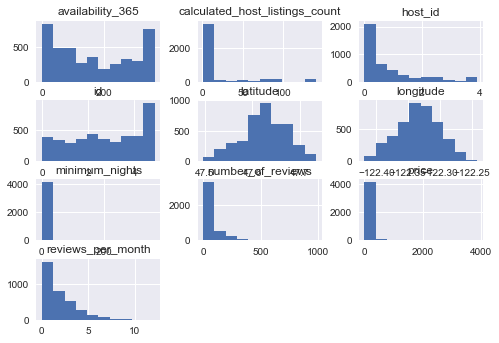

In [4]:
df_sea.hist();

#### Business Questions
the variable data shows that there are skewed distributions for number of reviews, reviews per month and price which would be interesting to investigate.

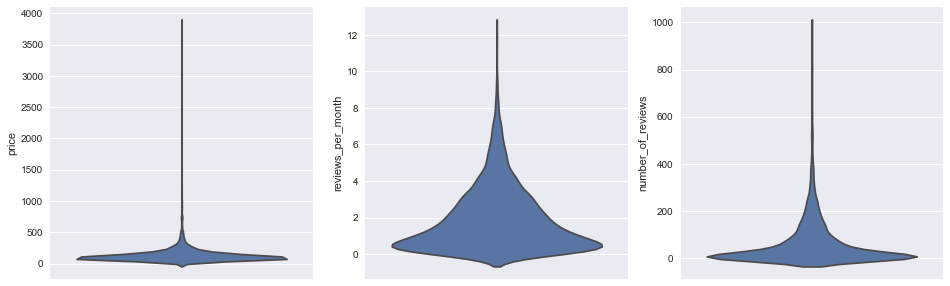

In [5]:
# Closer look at 'price', 'reviews_per_month' and 'number_of_reviews'
plt.figure(figsize = [16, 5])

plt.subplot(1, 3, 1)
sb.violinplot(data =df_sea, y = 'price', inner = None);

plt.subplot(1, 3, 2)
sb.violinplot(data =df_sea, y = 'reviews_per_month', inner = None);

plt.subplot(1, 3, 3)
sb.violinplot(data =df_sea, y = 'number_of_reviews', inner = None);

In [6]:
# investigate nulls for reviews per month
df_null_sea = df_sea[df_sea['reviews_per_month'].isnull()]
df_null_sea.number_of_reviews.describe()

count    723.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: number_of_reviews, dtype: float64

#### Data Cleaning and Quality Issues
* 'reviews_per_month' and 'last_review' contain nulls. Investigation shows that this is because there have been no reviews. Replace null with 0 in 'reviews_per_month', filter out nulls in 'last review' if necessary (This data is not needed to answer the Business Questions).
* 'host_name' contains nulls. Replace null with "Not given" in 'host_name'.
* 'neighbourhood_group' and 'neighbourhood' are both present here. Based on the analysis in `neighbourhoods.ipynb`, the column 'neighbourhood' in the Seattle data will not be used, with neighbourhood analysis referring to the column neighbourhood_group.
* The violin plots show signs of outliers for 'price', 'reviews_per_month' and 'number_of_reviews' that could distort the analysis, so will be filtered appropriately

In [7]:
# replace nulls with 0 in 'reviews_per_month'
df_sea['reviews_per_month'].fillna(0, inplace=True)

# replace nulls with 'Not given' in 'host_name'
df_sea['host_name'].fillna('Not given', inplace=True)

# drop column 'neighbourhood'
df_sea.drop(['neighbourhood'], axis=1, inplace=True)

In [8]:
# filter out outliers for 'price', 'reviews_per_month' and 'number_of_reviews':
df_sea = df_sea[(df_sea['price']< 2000)]
df_sea = df_sea[(df_sea['reviews_per_month']< 10)]
df_sea = df_sea[(df_sea['number_of_reviews']< 400)]

#### Create id integer values for category columns to facilitate co-relation analysis later
* neighbourhood
* room_type

In [9]:
# create a daframe that assigns a number to the room type
df_sea_room = pd.DataFrame({"room_type": list(df_sea.room_type.unique())}, dtype="category")
df_sea_room['room_type_id'] = list(range(len(df_sea_room.index)))
df_sea_room.head()

,room_type,room_type_id
0,Entire home/apt,0
1,Private room,1
2,Shared room,2
3,Hotel room,3


In [10]:
# create a daframe that assigns a number to the neighbourhood.
# this is being delibrately ranked on mean price 
# to see if there is a corellation between individual prices and the neighbourhood ,
df_sea_hood = df_sea.groupby(['neighbourhood_group'])['price'].mean()
df_sea_hood = df_sea_hood.sort_values().reset_index()
df_sea_hood['neighbourhood_id'] = list(range(len(df_sea_hood.index)))
df_sea_hood.rename(columns={'price':'mean_price'}, inplace=True)

df_sea_hood.head()

,neighbourhood_group,mean_price,neighbourhood_id
0,Northgate,90.428571,0
1,Delridge,92.168000,1
2,University District,104.253521,2
3,Beacon Hill,108.020725,3
4,Interbay,109.000000,4


In [11]:
df_sea = pd.merge(df_sea, df_sea_room, left_on='room_type', right_on='room_type', how='left')
df_sea = pd.merge(df_sea, df_sea_hood, left_on='neighbourhood_group', right_on='neighbourhood_group', how='left')
df_sea.dtypes

id                                  int64
name                               object
host_id                             int64
host_name                          object
neighbourhood_group                object
latitude                          float64
longitude                         float64
room_type                          object
price                               int64
minimum_nights                      int64
number_of_reviews                   int64
last_review                        object
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
room_type_id                        int64
mean_price                        float64
neighbourhood_id                    int64
dtype: object

In [12]:
#read in transit_access_data from seattle_access.csv
df_access_sea = pd.read_csv('./seattle_access.csv')

In [13]:
# merge transit airport parking olumns with main data set
# columns to merge
cols = (['id', 'transit', 'parking', 'airport'])
# merge
df_sea = df_sea.merge(df_access_sea[cols], left_on='id', right_on='id', how='left')
df_sea.head()

,id,name,host_id,host_name,neighbourhood_group,latitude,longitude,room_type,price,minimum_nights,...,last_review,reviews_per_month,calculated_host_listings_count,availability_365,room_type_id,mean_price,neighbourhood_id,transit,parking,airport
0,2318,Casa Madrona - Urban Oasis 1 block from the park!,2536,Megan,Central Area,47.61094,-122.29286,Entire home/apt,349,30,...,2020-02-01,0.21,2,107,0,141.188272,11,0,0,0
1,9419,Glorious sun room w/ memory foambed,30559,Angielena,Other neighborhoods,47.55017,-122.31937,Private room,55,2,...,2019-12-27,1.14,7,352,1,125.198684,8,0,0,0
2,9531,The Adorable Sweet Orange Craftsman,31481,Cassie,West Seattle,47.55539,-122.38474,Entire home/apt,165,3,...,2020-11-26,0.37,2,210,0,138.386029,10,0,0,0
3,9534,The Coolest Tangerine Dream MIL!,31481,Cassie,West Seattle,47.55624,-122.38598,Entire home/apt,125,3,...,2021-02-19,0.50,2,217,0,138.386029,10,0,0,0
4,9596,"the down home , spacious, central and fab!",14942,Joyce,Other neighborhoods,47.65479,-122.33652,Entire home/apt,100,4,...,2020-09-28,0.82,2,23,0,125.198684,8,0,0,0


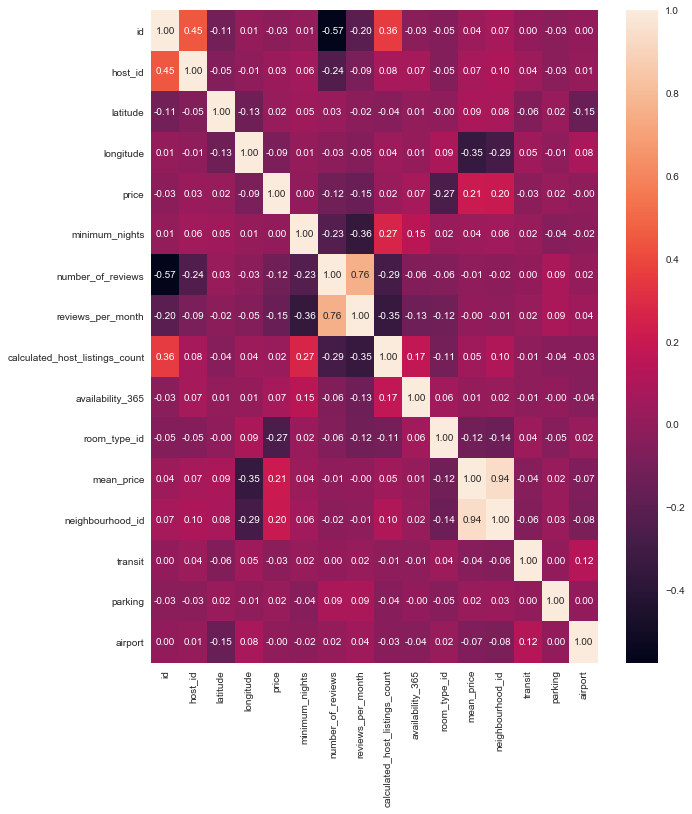

In [14]:
fig, ax = plt.subplots(figsize=(10,12))
sb.heatmap(df_sea.corr(), annot=True, fmt=".2f", ax=ax)
plt.show();

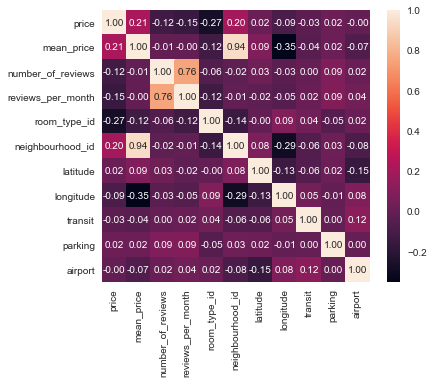

In [15]:
#reduce number of comparisons for report
cols = ['price','mean_price','number_of_reviews','reviews_per_month','room_type_id',
        'neighbourhood_id','latitude','longitude','transit','parking','airport']
fig, ax = plt.subplots(figsize=(6,5))
sb.heatmap(df_sea[cols].corr(), annot=True, fmt=".2f", ax=ax)
plt.savefig('seattle_corr.png')
plt.show();

* At first examination, the corelations between the variables are generally fairly weak, or at least not robust enough to make predictions.

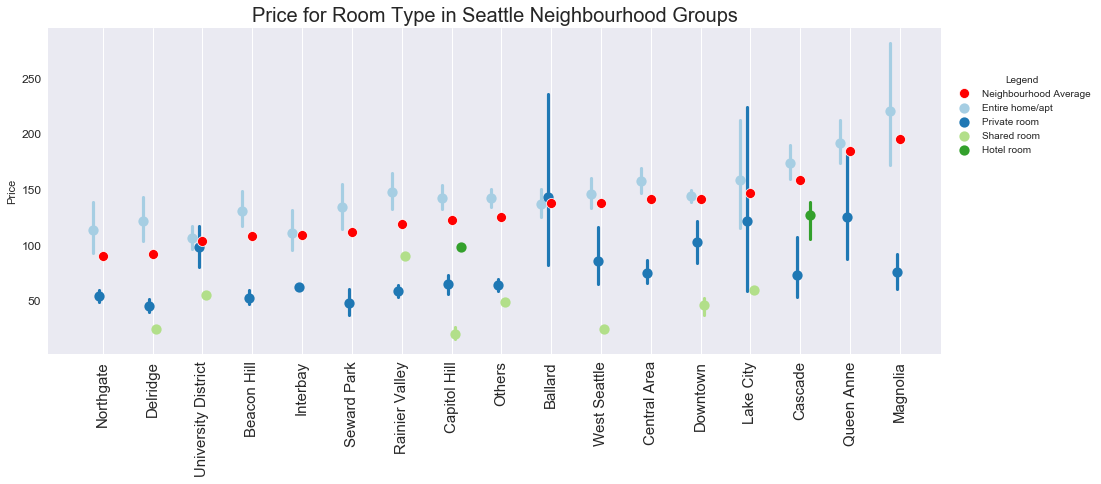

In [16]:
# change string Value in Neighborhood Groups column 
#"Other neighbourhoods" to "Others" to make x-axis more readable
df_sea_hood['neighbourhood_group'] = df_sea_hood['neighbourhood_group'].str.replace('Other neighborhoods','Others')

# plot for comapring prices of room types with the mean price for neighbourhoods
fig = plt.figure(figsize = [16,6])
ax = fig.add_subplot(111)

ax = sb.pointplot(data = df_sea, x = 'neighbourhood_id', y = 'price', hue = 'room_type',palette = 'Paired', linestyles = '', dodge =0.4)
ax = sb.lineplot(data = df_sea_hood, x = 'neighbourhood_id', y = 'mean_price', marker="o", ms=10, linewidth = 0, color = 'red', label='Neighbourhood Average')
plt.title('Price for Room Type in Seattle Neighbourhood Groups', size = 20)
plt.xticks(df_sea_hood.neighbourhood_id,df_sea_hood.neighbourhood_group, rotation=90, size = 15)
plt.yticks(size = 12)
plt.ylabel('Price')
plt.xlabel(None)
plt.grid()

leg = plt.legend(loc=(1.01,0.6), title="Legend")

plt.savefig('seattle_room.png')

plt.show();

For the report
* On the whole Private rooms cost less than Entire homes/appartments, although in some neighbourhoods they are the same.
* The ranking of mean price for neighbourhoods follows the ranking of the Entire homes/appartments categories, but because of the two districts University and Ballard where the prices are the same for both categories, together with Cascade and Magnolia whose private rooms also buck the trend, this ranking does not hold for private rooms. 

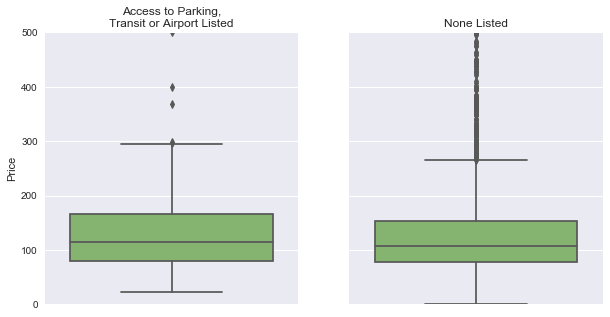

In [17]:
# Comparison of distributions of 'price' for Names mentioning Proximity to Airport, Transit or with Parking...
# ..vs Names not mentioning Proximity to Airport, Transit or with Parking

plt.figure(figsize = [10, 5])
           
# Boxplot showing distribution for Names mentioning Proximity to Airport, Transit or with Parking
plt.subplot(1, 2, 1)
plt.ylim([0, 500])
plt.title("Access to Parking,\nTransit or Airport Listed")
sb.boxplot(data =df_sea.query("transit == 1 or airport == 1 or parking == 1"), y = 'price',palette="summer").set(ylabel='Price');

# Boxplot showing distribution for Names not mentioning Proximity to Airport, Transit or with Parking
plt.subplot(1, 2, 2)
plt.ylim([0, 500])
plt.title("None Listed")
sb.boxplot(data =df_sea.query("transit == 0 and airport == 0 and parking == 0"), y = 'price',palette="summer").set(yticklabels=[],ylabel=None);

plt.savefig('seattle_access_price.png');

In [18]:
df_sea.query("transit == 1 or airport == 1 or parking == 1").price.describe()

count    207.000000
mean     134.874396
std       89.806554
min       22.000000
25%       79.000000
50%      115.000000
75%      165.500000
max      740.000000
Name: price, dtype: float64

In [19]:
df_sea.query("transit == 0 and airport == 0 and parking == 0").price.describe()

count    3956.000000
mean      133.780334
std       106.606608
min         0.000000
25%        78.000000
50%       107.000000
75%       153.000000
max      1500.000000
Name: price, dtype: float64

For the report:
* Median 115 vs 107
* 75% at least 79 vs 78

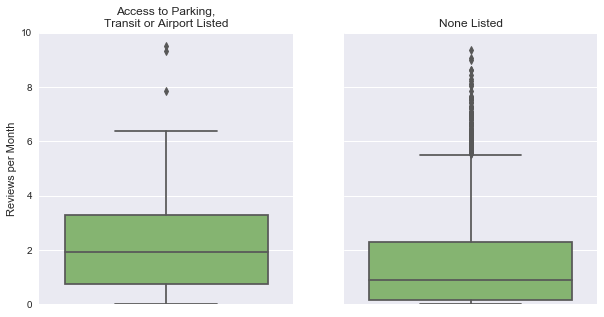

In [20]:
# Comparison of distributions of 'reviews_per_month' for Names mentioning Proximity to Airport, Transit or with Parking...
# ..vs Names not mentioning Proximity to Airport, Transit or with Parking

plt.figure(figsize = [10, 5])

# Boxplot showing distribution for Names mentioning Proximity to Airport, Transit or with Parking
plt.subplot(1, 2, 1)
plt.ylim([0, 10])
plt.title("Access to Parking,\nTransit or Airport Listed")
sb.boxplot(data =df_sea.query("transit == 1 or airport == 1 or parking == 1"), y = 'reviews_per_month',palette="summer").set(ylabel='Reviews per Month');

# Boxplot showing distribution for Names not mentioning Proximity to Airport, Transit or with Parking
plt.subplot(1, 2, 2)
plt.ylim([0, 10])
plt.title("None Listed")
sb.boxplot(data =df_sea.query("transit == 0 and airport == 0 and parking == 0"), y = 'reviews_per_month',palette="summer").set(yticklabels=[],ylabel=None);

plt.savefig('seattle_access_revabs.png');

In [21]:
df_sea.query("transit == 1 or airport == 1 or parking == 1").reviews_per_month.describe()

count    207.000000
mean       2.181353
std        1.734239
min        0.000000
25%        0.755000
50%        1.930000
75%        3.300000
max        9.520000
Name: reviews_per_month, dtype: float64

In [22]:
df_sea.query("transit == 0 and airport == 0 and parking == 0").reviews_per_month.describe()

count    3956.000000
mean        1.473319
std         1.636127
min         0.000000
25%         0.170000
50%         0.910000
75%         2.310000
max         9.370000
Name: reviews_per_month, dtype: float64

For the report:
* Median 1.93 vs 0.91
* 75% at least 0.75 vs 0.17

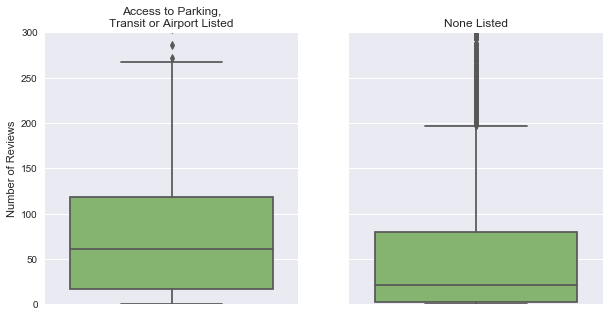

In [23]:
# Comparison of distributions of 'number_of_reviews' for Names mentioning Proximity to Airport, Transit or with Parking...
# ..vs Names not mentioning Proximity to Airport, Transit or with Parking
plt.figure(figsize = [10, 5])

# Boxplot showing distribution for Names mentioning Proximity to Airport, Transit or with Parking
plt.subplot(1, 2, 1)
plt.ylim([0, 300])
plt.title("Access to Parking,\nTransit or Airport Listed")
sb.boxplot(data =df_sea.query("transit == 1 or airport == 1 or parking == 1"), y = 'number_of_reviews',palette="summer").set(ylabel='Number of Reviews');

# Boxplot showing distribution for Names not mentioning Proximity to Airport, Transit or with Parking
plt.subplot(1, 2, 2)
plt.ylim([0, 300])
plt.title("None Listed")
sb.boxplot(data =df_sea.query("transit == 0 and airport == 0 and parking == 0"), y = 'number_of_reviews',palette="summer").set(yticklabels=[],ylabel=None);

plt.savefig('seattle_access_revpro.png');

In [24]:
df_sea.query("transit == 1 or airport == 1 or parking == 1").number_of_reviews.describe()

count    207.000000
mean      82.362319
std       80.207735
min        0.000000
25%       17.000000
50%       61.000000
75%      118.500000
max      372.000000
Name: number_of_reviews, dtype: float64

In [25]:
df_sea.query("transit == 0 and airport == 0 and parking == 0").number_of_reviews.describe()

count    3956.000000
mean       55.716633
std        77.592995
min         0.000000
25%         2.000000
50%        21.000000
75%        80.000000
max       399.000000
Name: number_of_reviews, dtype: float64

For the report:
* Median 61 vs 21
* 75% at least 17 vs 2

#### Conclusion
* for Price this shows a slightly higher percentage of entries that mention these access factors have hogher prices than those that don't.
* Whilst not very many advertise these access factors (207 / 3956 6%), a higher percentage of them recieve a higher number of reviews, and a higher number of reviews per month than than without.

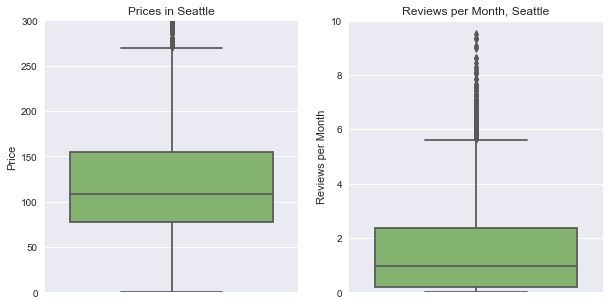

In [26]:
#Boxplots for comparison of Seattle and Boston

plt.subplots(figsize=(10,5))

# Box Plot prices Seattle
plt.subplot(1, 2, 1)
plt.ylim([0, 300])
plt.title('Prices in Seattle')
sb.boxplot(data =df_sea, y = 'price',palette="summer").set(ylabel='Price');

# Box Plot reviews_per_month Seattle
plt.subplot(1, 2, 2)
plt.ylim([0, 10])
plt.title('Reviews per Month, Seattle')
sb.boxplot(data =df_sea, y = 'reviews_per_month',palette="summer").set(ylabel='Reviews per Month');

plt.savefig('seattle_compare.png');